In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (StrMethodFormatter, AutoMinorLocator)
from matplotlib.animation import FuncAnimation
from netCDF4 import Dataset

In [2]:
# set up Li-Ion half cell SPM model with the Chen2020 parameter values
model = pybamm.lithium_ion.SPM({"working electrode": "positive"})
parameter_values = pybamm.ParameterValues('Chen2020')

In [3]:
# Simulation 1 - Charging at -5 A and 0% SOC

# Positive electrode - adjusted Chen2020 input parameters to fit own input parameters for 
parameter_values['Ambient temperature [K]'] = 294.15
parameter_values['Initial temperature [K]'] = 294.15
parameter_values['Reference temperature [K]'] = 294.15
parameter_values['Positive electrode diffusivity [m2.s-1]'] = 1.48*10**(-15)
parameter_values['Maximum concentration in positive electrode [mol.m-3]'] = 51765.0
parameter_values['Initial concentration in positive electrode [mol.m-3]'] = 47023.326
parameter_values['Current function [A]'] = -5.0
# set input parameters for negative Li electrode for half-SPM model
parameter_values["Negative electrode OCP [V]"] = 0.0
parameter_values["Negative electrode conductivity [S.m-1]"] = 10776000.0
parameter_values["Negative electrode OCP entropic change [V.K-1]"] = 0.0
parameter_values["Negative electrode charge transfer coefficient"] = 0.5
parameter_values["Negative electrode double-layer capacity [F.m-2]"] = 0.2
parameter_values.update({"Typical plated lithium concentration [mol.m-3]" : 76900.0}, check_already_exists=False)
# define function for electrolte exchange current density and set it as input parameter
def li_metal_electrolyte_exchange_current_density_Xu2019(c_e, c_Li, T):
    m_ref = 3.5e-8 * pybamm.constants.F  # (A/m2)(mol/m3) - includes ref concentrations

    return m_ref * c_Li**0.7 * c_e**0.3
parameter_values.update({"Exchange-current density for plating [A.m-2]" : li_metal_electrolyte_exchange_current_density_Xu2019}, 
                        check_already_exists=False)

# run the simulation with 120 evaluation steps
sim_1 = pybamm.Simulation(model, parameter_values=parameter_values)
t_eval = np.arange(0,1000,1)
sim_1.solve(t_eval = t_eval)
#sim.plot()

# Get computed quantities of interest
v_1 = sim_1.solution['Voltage [V]'].data
c_1 = sim_1.solution['Positive particle concentration [mol.m-3]'].data[:,0]
t_1 = sim_1.solution['Time [s]'].data
r_1 = sim_1.solution['r_p [m]'].data[:,0,0]

In [5]:
print(c_1.shape)

(20, 1000)


In [6]:
# write NetCDF file for simulation 1
rootgrp = Dataset('./data/PyBaMM_sim1.nc', 'w', format='NETCDF4')
v_dim = rootgrp.createDimension('v_dim', len(v_1))
c_xdim = rootgrp.createDimension('c_xdim', c_1.shape[0] )
c_ydim = rootgrp.createDimension('c_ydim', c_1.shape[1])
t_dim = rootgrp.createDimension('t_dim', len(t_1))
r_dim = rootgrp.createDimension('r_dim', len(r_1))
volt = rootgrp.createVariable('volt', 'f8', ('v_dim',))
conc = rootgrp.createVariable('conc', 'f8', ('c_xdim', 'c_ydim',))
time = rootgrp.createVariable('time', 'f8', ('t_dim',))
rad = rootgrp.createVariable('rad', 'f8', ('r_dim',))
rootgrp.description = 'Result from PyBaMM charging at fixed current'
volt.description = 'Voltage'
volt.units = 'V'
conc.description = 'Lithium concentration'
conc.units = '$mol m^{-3}$'
time.description = 'Time'
time.units = 's'
rad.description = 'Mean particle radius'
rad.units = 'm'
volt[:] = v_1
conc[:,:] = c_1
time[:] = t_1
rad[:] = r_1
rootgrp.close()

In [7]:
# Simulation 2 - Discharging at -5 A and 95% SOC 
# Initial concentration at 100% SOC leads to following error:
# Events ['Maximum voltage [V]'] are non-positive at initial conditions

# Positive electrode - adjusted Chen2020 input parameters to fit own input parameters for 
parameter_values['Ambient temperature [K]'] = 294.15
parameter_values['Initial temperature [K]'] = 294.15
parameter_values['Reference temperature [K]'] = 294.15
parameter_values['Positive electrode diffusivity [m2.s-1]'] = 1.48*10**(-15)
parameter_values['Maximum concentration in positive electrode [mol.m-3]'] = 51765.0
parameter_values['Initial concentration in positive electrode [mol.m-3]'] = 15437.099475
parameter_values['Current function [A]'] = +5.0
# set input parameters for negative Li electrode for half-SPM model
parameter_values["Negative electrode OCP [V]"] = 0.0
parameter_values["Negative electrode conductivity [S.m-1]"] = 10776000.0
parameter_values["Negative electrode OCP entropic change [V.K-1]"] = 0.0
parameter_values["Negative electrode charge transfer coefficient"] = 0.5
parameter_values["Negative electrode double-layer capacity [F.m-2]"] = 0.2
parameter_values.update({"Typical plated lithium concentration [mol.m-3]" : 76900.0}, check_already_exists=False)
# define function for electrolte exchange current density and set it as input parameter
def li_metal_electrolyte_exchange_current_density_Xu2019(c_e, c_Li, T):
    m_ref = 3.5e-8 * pybamm.constants.F  # (A/m2)(mol/m3) - includes ref concentrations

    return m_ref * c_Li**0.7 * c_e**0.3
parameter_values.update({"Exchange-current density for plating [A.m-2]" : li_metal_electrolyte_exchange_current_density_Xu2019}, 
                        check_already_exists=False)

# run the simulation with 120 evaluation steps
sim_2 = pybamm.Simulation(model, parameter_values=parameter_values)
t_eval = np.arange(0,1000,1)
sim_2.solve(t_eval=t_eval)
#sim.plot()

# Get computed quantities of interest
v_2 = sim_2.solution['Voltage [V]'].data
c_2 = sim_2.solution['Positive particle concentration [mol.m-3]'].data[:,0]
t_2 = sim_2.solution['Time [s]'].data
r_2 = sim_2.solution['r_p [m]'].data[:,0,0]

In [7]:
# write NetCDF file for simulation 2
rootgrp = Dataset('./data/PyBaMM_sim2.nc', 'w', format='NETCDF4')
v_dim = rootgrp.createDimension('v_dim', len(v_2))
c_xdim = rootgrp.createDimension('c_xdim', c_2.shape[0] )
c_ydim = rootgrp.createDimension('c_ydim', c_2.shape[1])
t_dim = rootgrp.createDimension('t_dim', len(t_2))
r_dim = rootgrp.createDimension('r_dim', len(r_2))
volt = rootgrp.createVariable('volt', 'f8', ('v_dim',))
conc = rootgrp.createVariable('conc', 'f8', ('c_xdim', 'c_ydim',))
time = rootgrp.createVariable('time', 'f8', ('t_dim',))
rad = rootgrp.createVariable('rad', 'f8', ('r_dim',))
rootgrp.description = 'Result from PyBaMM discharging at fixed current'
volt.description = 'Voltage'
volt.units = 'V'
conc.description = 'Lithium concentration'
conc.units = '$mol m^{-3}$'
time.description = 'Time'
time.units = 's'
rad.description = 'Mean particle radius'
rad.units = 'm'
volt[:] = v_2
conc[:,:] = c_2
time[:] = t_2
rad[:] = r_2
rootgrp.close()

2023-05-24 14:24:37.462 - [NOTICE] callbacks.on_cycle_start(172): Cycle 1/1 (78.013 us elapsed) --------------------
2023-05-24 14:24:37.463 - [NOTICE] callbacks.on_step_start(180): Cycle 1/1, step 1/3: Rest for 30 minutes
2023-05-24 14:24:37.471 - [NOTICE] callbacks.on_step_start(180): Cycle 1/1, step 2/3: Discharge at 1 A for 5 minutes
2023-05-24 14:24:37.482 - [NOTICE] callbacks.on_step_start(180): Cycle 1/1, step 3/3: Rest for 30 minutes
2023-05-24 14:24:37.505 - [NOTICE] callbacks.on_experiment_end(220): Finish experiment simulation, took 43.124 ms


interactive(children=(FloatSlider(value=0.0, description='t', max=1.0833333333333333, step=0.01083333333333333…

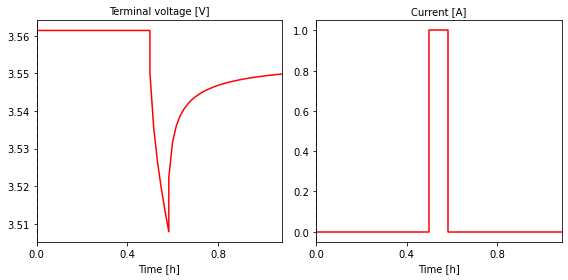

In [21]:
# Simulation 3 - GITT experiment
pybamm.set_logging_level('NOTICE')
experiment = pybamm.Experiment(
    [
        ("Rest for 30 minutes",
        "Discharge at 1 A for 5 minutes",
        "Rest for 30 minutes"),
    ])

# Positive electrode - adjusted Chen2020 input parameters to fit own input parameters for 
parameter_values['Ambient temperature [K]'] = 294.15
parameter_values['Initial temperature [K]'] = 294.15
parameter_values['Reference temperature [K]'] = 294.15
parameter_values['Positive electrode diffusivity [m2.s-1]'] = 1.48*10**(-15)
parameter_values['Maximum concentration in positive electrode [mol.m-3]'] = 51765.0
parameter_values['Initial concentration in positive electrode [mol.m-3]'] = 47023.326
parameter_values['Current function [A]'] = -5.0
# set input parameters for negative Li electrode for half-SPM model
parameter_values["Negative electrode OCP [V]"] = 0.0
parameter_values["Negative electrode conductivity [S.m-1]"] = 10776000.0
parameter_values["Negative electrode OCP entropic change [V.K-1]"] = 0.0
parameter_values["Negative electrode charge transfer coefficient"] = 0.5
parameter_values["Negative electrode double-layer capacity [F.m-2]"] = 0.2
parameter_values.update({"Typical plated lithium concentration [mol.m-3]" : 76900.0}, check_already_exists=False)
# define function for electrolte exchange current density and set it as input parameter
def li_metal_electrolyte_exchange_current_density_Xu2019(c_e, c_Li, T):
    m_ref = 3.5e-8 * pybamm.constants.F  # (A/m2)(mol/m3) - includes ref concentrations

    return m_ref * c_Li**0.7 * c_e**0.3
parameter_values.update({"Exchange-current density for plating [A.m-2]" : li_metal_electrolyte_exchange_current_density_Xu2019}, 
                        check_already_exists=False)

# run simulation
sim_exp = pybamm.Simulation(model, parameter_values = parameter_values, experiment = experiment)
sim_exp.solve()
sim_exp.plot(['Terminal voltage [V]', 'Current [A]'])

# Get computed quantities of interest
v_3 = sim_exp.solution['Voltage [V]'].data
c_3 = sim_exp.solution['Positive particle concentration [mol.m-3]'].data[:,0]
t_3 = sim_exp.solution['Time [s]'].data
r_3 = sim_exp.solution['r_p [m]'].data[:,0,0]

In [23]:
print(t_3)

[   0.   60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.
  720.  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380.
 1440. 1500. 1560. 1620. 1680. 1740. 1800. 1800. 1860. 1920. 1980. 2040.
 2100. 2100. 2160. 2220. 2280. 2340. 2400. 2460. 2520. 2580. 2640. 2700.
 2760. 2820. 2880. 2940. 3000. 3060. 3120. 3180. 3240. 3300. 3360. 3420.
 3480. 3540. 3600. 3660. 3720. 3780. 3840. 3900.]


In [9]:
# write NetCDF file for simulation 3
rootgrp = Dataset('./data/PyBaMM_sim3.nc', 'w', format='NETCDF4')
v_dim = rootgrp.createDimension('v_dim', len(v_3))
c_xdim = rootgrp.createDimension('c_xdim', c_3.shape[0] )
c_ydim = rootgrp.createDimension('c_ydim', c_3.shape[1])
t_dim = rootgrp.createDimension('t_dim', len(t_3))
r_dim = rootgrp.createDimension('r_dim', len(r_3))
volt = rootgrp.createVariable('volt', 'f8', ('v_dim',))
conc = rootgrp.createVariable('conc', 'f8', ('c_xdim', 'c_ydim',))
time = rootgrp.createVariable('time', 'f8', ('t_dim',))
rad = rootgrp.createVariable('rad', 'f8', ('r_dim',))
rootgrp.description = 'Result from PyBaMM for GITT experiment'
volt.description = 'Voltage'
volt.units = 'V'
conc.description = 'Lithium concentration'
conc.units = '$mol m^{-3}$'
time.description = 'Time'
time.units = 's'
rad.description = 'Mean particle radius'
rad.units = 'm'
volt[:] = v_3
conc[:,:] = c_3
time[:] = t_3
rad[:] = r_3
rootgrp.close()

In [10]:
#parameter_values

In [11]:
# Simulation 4 - Charging at -5 A and 0% SOC with Diffusion coefficient of 4*10^(-10)

# Positive electrode - adjusted Chen2020 input parameters to fit own input parameters for 
parameter_values['Ambient temperature [K]'] = 294.15
parameter_values['Initial temperature [K]'] = 294.15
parameter_values['Reference temperature [K]'] = 294.15
parameter_values['Positive electrode diffusivity [m2.s-1]'] = 1.48*10**(-15)
parameter_values['Maximum concentration in positive electrode [mol.m-3]'] = 51765.0
parameter_values['Initial concentration in positive electrode [mol.m-3]'] = 47023.326
parameter_values['Current function [A]'] = -5.0
parameter_values['Positive electrode diffusivity [m2.s-1]'] = 4*10**(-10)
# set input parameters for negative Li electrode for half-SPM model
parameter_values["Negative electrode OCP [V]"] = 0.0
parameter_values["Negative electrode conductivity [S.m-1]"] = 10776000.0
parameter_values["Negative electrode OCP entropic change [V.K-1]"] = 0.0
parameter_values["Negative electrode charge transfer coefficient"] = 0.5
parameter_values["Negative electrode double-layer capacity [F.m-2]"] = 0.2
parameter_values.update({"Typical plated lithium concentration [mol.m-3]" : 76900.0}, check_already_exists=False)
# define function for electrolte exchange current density and set it as input parameter
def li_metal_electrolyte_exchange_current_density_Xu2019(c_e, c_Li, T):
    m_ref = 3.5e-8 * pybamm.constants.F  # (A/m2)(mol/m3) - includes ref concentrations

    return m_ref * c_Li**0.7 * c_e**0.3
parameter_values.update({"Exchange-current density for plating [A.m-2]" : li_metal_electrolyte_exchange_current_density_Xu2019}, 
                        check_already_exists=False)

# run the simulation with 120 evaluation steps
sim_4 = pybamm.Simulation(model, parameter_values=parameter_values)
t_eval = np.arange(0,1000,1)
sim_4.solve(t_eval=t_eval)
#sim.plot()

# Get computed quantities of interest
v_4 = sim_4.solution['Voltage [V]'].data
c_4 = sim_4.solution['Positive particle concentration [mol.m-3]'].data[:,0]
t_4 = sim_4.solution['Time [s]'].data
r_4 = sim_4.solution['r_p [m]'].data[:,0,0]

In [12]:
# write NetCDF file for simulation 4
rootgrp = Dataset('./data/PyBaMM_sim4.nc', 'w', format='NETCDF4')
v_dim = rootgrp.createDimension('v_dim', len(v_4))
c_xdim = rootgrp.createDimension('c_xdim', c_4.shape[0] )
c_ydim = rootgrp.createDimension('c_ydim', c_4.shape[1])
t_dim = rootgrp.createDimension('t_dim', len(t_4))
r_dim = rootgrp.createDimension('r_dim', len(r_4))
volt = rootgrp.createVariable('volt', 'f8', ('v_dim',))
conc = rootgrp.createVariable('conc', 'f8', ('c_xdim', 'c_ydim',))
time = rootgrp.createVariable('time', 'f8', ('t_dim',))
rad = rootgrp.createVariable('rad', 'f8', ('r_dim',))
rootgrp.description = 'Result from PyBaMM for GITT experiment'
volt.description = 'Voltage'
volt.units = 'V'
conc.description = 'Lithium concentration'
conc.units = '$mol m^{-3}$'
time.description = 'Time'
time.units = 's'
rad.description = 'Mean particle radius'
rad.units = 'm'
volt[:] = v_4
conc[:,:] = c_4
time[:] = t_4
rad[:] = r_4
rootgrp.close()

In [11]:
# Simulation 5 - Charging at -5 A and 0% SOC with Mean partile radius of 7 micrometer

# Positive electrode - adjusted Chen2020 input parameters to fit own input parameters for 
parameter_values['Ambient temperature [K]'] = 294.15
parameter_values['Initial temperature [K]'] = 294.15
parameter_values['Reference temperature [K]'] = 294.15
parameter_values['Positive electrode diffusivity [m2.s-1]'] = 1.48*10**(-15)
parameter_values['Maximum concentration in positive electrode [mol.m-3]'] = 51765.0
parameter_values['Initial concentration in positive electrode [mol.m-3]'] = 47023.326
parameter_values['Current function [A]'] = -5.0
parameter_values['Positive electrode diffusivity [m2.s-1]'] = 1.48*10**(-15)
parameter_values['Positive particle radius [m]'] = 7.0*10**(-6)
# set input parameters for negative Li electrode for half-SPM model
parameter_values["Negative electrode OCP [V]"] = 0.0
parameter_values["Negative electrode conductivity [S.m-1]"] = 10776000.0
parameter_values["Negative electrode OCP entropic change [V.K-1]"] = 0.0
parameter_values["Negative electrode charge transfer coefficient"] = 0.5
parameter_values["Negative electrode double-layer capacity [F.m-2]"] = 0.2
parameter_values.update({"Typical plated lithium concentration [mol.m-3]" : 76900.0}, check_already_exists=False)
# define function for electrolte exchange current density and set it as input parameter
def li_metal_electrolyte_exchange_current_density_Xu2019(c_e, c_Li, T):
    m_ref = 3.5e-8 * pybamm.constants.F  # (A/m2)(mol/m3) - includes ref concentrations

    return m_ref * c_Li**0.7 * c_e**0.3
parameter_values.update({"Exchange-current density for plating [A.m-2]" : li_metal_electrolyte_exchange_current_density_Xu2019}, 
                        check_already_exists=False)

# run the simulation with 120 evaluation steps
sim_5 = pybamm.Simulation(model, parameter_values=parameter_values)
t_eval = np.arange(0,1000,1)
sim_5.solve(t_eval=t_eval)
#sim.plot()

# Get computed quantities of interest
v_5 = sim_5.solution['Voltage [V]'].data
c_5 = sim_5.solution['Positive particle concentration [mol.m-3]'].data[:,0]
t_5 = sim_5.solution['Time [s]'].data
r_5 = sim_5.solution['r_p [m]'].data[:,0,0]

In [12]:
# write NetCDF file for simulation 5
rootgrp = Dataset('./data/PyBaMM_sim5.nc', 'w', format='NETCDF4')
v_dim = rootgrp.createDimension('v_dim', len(v_5))
c_xdim = rootgrp.createDimension('c_xdim', c_5.shape[0] )
c_ydim = rootgrp.createDimension('c_ydim', c_5.shape[1])
t_dim = rootgrp.createDimension('t_dim', len(t_5))
r_dim = rootgrp.createDimension('r_dim', len(r_5))
volt = rootgrp.createVariable('volt', 'f8', ('v_dim',))
conc = rootgrp.createVariable('conc', 'f8', ('c_xdim', 'c_ydim',))
time = rootgrp.createVariable('time', 'f8', ('t_dim',))
rad = rootgrp.createVariable('rad', 'f8', ('r_dim',))
rootgrp.description = 'Result from PyBaMM for GITT experiment'
volt.description = 'Voltage'
volt.units = 'V'
conc.description = 'Lithium concentration'
conc.units = '$mol m^{-3}$'
time.description = 'Time'
time.units = 's'
rad.description = 'Mean particle radius'
rad.units = 'm'
volt[:] = v_5
conc[:,:] = c_5
time[:] = t_5
rad[:] = r_5
rootgrp.close()

interactive(children=(FloatSlider(value=0.0, description='t', max=999.0, step=9.99), Output()), _dom_classes=(…

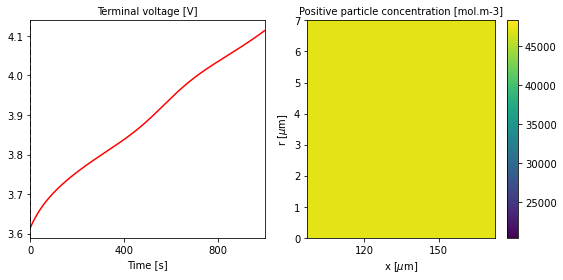

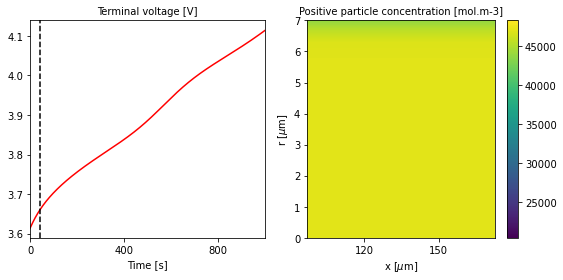

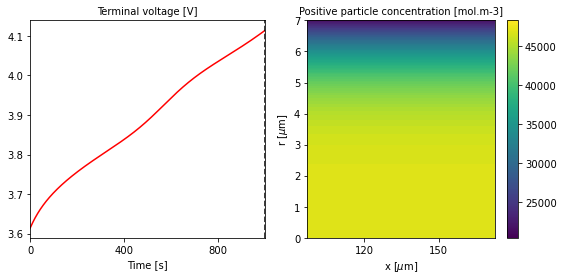

In [13]:
sim_5.plot(['Terminal voltage [V]', 'Positive particle concentration [mol.m-3]'])

NameError: name 'r' is not defined

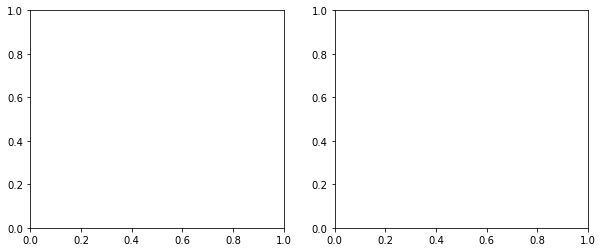

In [16]:
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot2grid((1,2),(0,0))
ax2 = plt.subplot2grid((1,2),(0,1))

intervaltime = 10
line, = ax1.plot(r, c[:,0])
def animate(i):
    line.set_ydata(c[:,i])
    return line,
animation = FuncAnimation(fig, animate, interval=intervaltime, frames=time_axis, blit=True)

ax1.set_xlabel('Distance from particle centre [$\mu m$]', size=8)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(axis='x', labelsize=7)
ax1.set_ylabel('Lithium concentration $mol*m^{-3}$', size=8)
ax1.set_ylim(np.min(c), np.max(c))
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(axis='y', labelsize=7)
ax1.ticklabel_format(axis='both', style="sci", useMathText=True)
ax1.xaxis.offsetText.set_fontsize(7)
ax1.yaxis.offsetText.set_fontsize(7)
ax1.set_title('Lithium Concentration Across Particle Radius', size=10, pad=15.0)

#animation.save('PyBaMM_1.mp4')
plt.show()